## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import inspect

import category_encoders as ce #if i switch count encoder method so that i can use fit_transform


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#from kmodes.kmodes import KModes
from math import ceil

from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

## Loading variables

In [4]:
with open('mode_stats.py', 'r') as f:
    function_code = f.read()

# Execute the code to define the function
exec(function_code)

## Uploading datasets

In [6]:
X_train = pd.read_csv('X_train.csv', index_col=0)
X_val = pd.read_csv('X_val.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)

In [7]:
y_train = pd.read_csv("y_train.csv", index_col=0)
y_val = pd.read_csv("y_val.csv", index_col=0)
#uploading it as a 1-column dataframe while preserving its index, to make sure it aligns

In [8]:
y_train = y_train.iloc[:, 0]
y_val = y_val.iloc[:, 0]
#turning it back into a panda series, so i can perform certain operations like Chi-Square Independence Test

In [9]:
X_train.shape

(401818, 33)

In [10]:
X_val.shape

(172208, 33)

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387975 entries, 0 to 387974
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   387975 non-null  int64  
 1   Age at Injury                   387975 non-null  int64  
 2   Alternative Dispute Resolution  387975 non-null  int64  
 3   Assembly Year                   387975 non-null  int64  
 4   Attorney/Representative         387975 non-null  int64  
 5   Average Weekly Wage             387975 non-null  float64
 6   Birth Year                      387975 non-null  int64  
 7   Carrier Name                    387975 non-null  object 
 8   Carrier Type                    387975 non-null  int64  
 9   Claim Identifier                387975 non-null  int64  
 10  County of Injury                387975 non-null  object 
 11  COVID-19 Indicator              387975 non-null  int64  
 12  District Name        

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 65312 to 133536
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   401818 non-null  int64  
 1   Age at Injury                   401818 non-null  int64  
 2   Alternative Dispute Resolution  401818 non-null  int64  
 3   Assembly Year                   401818 non-null  int64  
 4   Attorney/Representative         401818 non-null  int64  
 5   Average Weekly Wage             401818 non-null  float64
 6   Birth Year                      401818 non-null  int64  
 7   Carrier Name                    401818 non-null  object 
 8   Carrier Type                    401818 non-null  int64  
 9   Claim Identifier                401818 non-null  int64  
 10  County of Injury                401818 non-null  object 
 11  COVID-19 Indicator              401818 non-null  int64  
 12  District Name    

## 3. Encoding

### 3.1 Evaluation of best technique

In [15]:
X_train.columns

Index(['Accident Year', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Year', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'Claim Identifier',
       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'First Hearing', 'C-3 Delivery', 'C-2 Delivery',
       'Days from Accident to C-2', 'Days from Accident to Assembly',
       'C-2 under Deadline', 'C-3 under Deadline', 'Forms Deadline',
       'Forms Delivered Count', 'Claim Antiguity', 'Valid Full Claim'],
      dtype='object')

In [16]:
X_train.select_dtypes(include='object').nunique()

Carrier Name                 1969
County of Injury               62
District Name                   8
WCIO Cause of Injury Code      75
WCIO Part Of Body Code         55
C-2 under Deadline              3
C-3 under Deadline              4
dtype: int64

In [17]:
X_test.select_dtypes(include='object').nunique()

Carrier Name                 1598
County of Injury               62
District Name                   8
WCIO Cause of Injury Code      75
WCIO Part Of Body Code         52
C-2 under Deadline              3
C-3 under Deadline              4
dtype: int64

In [18]:
X_train.select_dtypes(include='object').apply(lambda x: x.unique(), axis=0)

Carrier Name                 [STATE INSURANCE FUND, SIRIUSPOINT AMERICA INS...
County of Injury             [CAYUGA, QUEENS, MONROE, ALBANY, KINGS, WESTCH...
District Name                [SYRACUSE, NYC, ROCHESTER, ALBANY, BINGHAMTON,...
WCIO Cause of Injury Code    [53.0, 31.0, 56.0, 32.0, 29.0, 83.0, 74.0, 60....
WCIO Part Of Body Code       [55.0, 65.0, 38.0, 32.0, 90.0, 60.0, 56.0, 10....
C-2 under Deadline                                            [yes, no, error]
C-3 under Deadline                                   [no info, yes, no, error]
dtype: object

In [19]:
X_test.select_dtypes(include='object').apply(lambda x: x.unique(), axis=0)

Carrier Name                 [INDEMNITY INSURANCE CO OF, A I U INSURANCE CO...
County of Injury             [BRONX, QUEENS, WESTCHESTER, KINGS, ORANGE, NI...
District Name                [NYC, ALBANY, BUFFALO, SYRACUSE, BINGHAMTON, H...
WCIO Cause of Injury Code    [31.0, 75.0, 68.0, 25.0, 79.0, 90.0, 56.0, 27....
WCIO Part Of Body Code       [54.0, 10.0, 62.0, 53.0, 37.0, 66.0, 38.0, 14....
C-2 under Deadline                                            [yes, no, error]
C-3 under Deadline                                   [no info, no, yes, error]
dtype: object

In [20]:
np.all(np.isin(X_test['Carrier Name'].unique(), X_train['Carrier Name'].unique()))
#Checking which categorical features have different categories in test comparing to train

False

In [21]:
set(X_train['WCIO Nature of Injury Code'].unique()) == set(X_test['WCIO Nature of Injury Code'].unique())
#Checking if uniques of train are the same in test

True

In [22]:
len(np.setdiff1d(X_test['Carrier Type'].unique(), X_train['Carrier Type'].unique()))

0

In [23]:
# Find columns with 'U', 'UK', or 'Unknown' values and count occurrences
counts = (X_train == 'MISSING').sum()

# Filter to show only columns with at least one 'U' value
counts = counts[counts > 0]

counts

WCIO Cause of Injury Code    10945
WCIO Part Of Body Code       11919
dtype: int64

In [24]:
# Find columns with 'U', 'UK', or 'Unknown' values and count occurrences
counts = (X_val == 'MISSING').sum()

# Filter to show only columns with at least one 'U' value
counts = counts[counts > 0]

counts

WCIO Cause of Injury Code    4695
WCIO Part Of Body Code       5163
dtype: int64

In [25]:
missing = ['WCIO Cause of Injury Code','WCIO Part Of Body Code']

In [26]:
missing_mode = mode_stats(X_train, missing)
missing_mode

,Mode,Frequency,Frequency %,Unique Count,Ratio,Rows to fill,to fill %
Column,,,,,,,
WCIO Cause of Injury Code,56.0,32701,8.14%,75,0.0886,0,0.0
WCIO Part Of Body Code,42.0,36243,9.02%,55,0.0991,0,0.0


In [27]:
for column in missing:
    X_train[column] = X_train[column].replace('MISSING', (missing_mode.loc[column, 'Mode']))
    X_val[column] = X_val[column].replace('MISSING', (missing_mode.loc[column, 'Mode']))
    X_test[column] = X_test[column].replace('MISSING', (missing_mode.loc[column, 'Mode']))

In [28]:
# Find columns with 'U', 'UK', or 'Unknown' values and count occurrences
counts = (X_test == 'MISSING').sum()

# Filter to show only columns with at least one 'U' value
counts = counts[counts > 0]

counts

Series([], dtype: int64)

In [29]:
X_test.columns == X_val.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

`Dummy variables/One Hot encoding`
Use for variables with low number of unique values, since it will turn each unique variable into a column

In [31]:
dummy_cols = ['District Name', 'C-2 under Deadline', 'C-3 under Deadline', 'Carrier Type','Medical Fee Region']

In [32]:
# Apply pd.get_dummies to specified columns in X_train, X_val, and X_test
X_train = pd.get_dummies(X_train, columns=dummy_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=dummy_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=dummy_cols, drop_first=True)

In [33]:
X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [34]:
X_train.columns

Index(['Accident Year', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Year', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'First Hearing', 'C-3 Delivery', 'C-2 Delivery',
       'Days from Accident to C-2', 'Days from Accident to Assembly',
       'Forms Deadline', 'Forms Delivered Count', 'Claim Antiguity',
       'Valid Full Claim', 'District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE', 'C-2 under Deadline_no',
       'C-2 under Deadline_yes', 'C-3 under Deadline_no',
       'C-3 under Deadline_no info', 'C-3 under Deadline_yes'

In [35]:
X_train = X_train.replace({True: 1, False: 0})
X_val = X_val.replace({True: 1, False: 0})
X_test = X_test.replace({True: 1, False: 0})

In [36]:
dummy_to_object = ['District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE','C-2 under Deadline_no',
       'C-2 under Deadline_yes', 'C-3 under Deadline_no',
       'C-3 under Deadline_no info', 'C-3 under Deadline_yes',
       'Carrier Type_2', 'Carrier Type_3', 'Carrier Type_4', 'Carrier Type_5',
       'Medical Fee Region_2', 'Medical Fee Region_3', 'Medical Fee Region_4']

In [37]:
X_train[dummy_to_object] = X_train[dummy_to_object].astype('object')
X_val[dummy_to_object] = X_val[dummy_to_object].astype('object')
X_test[dummy_to_object] = X_test[dummy_to_object].astype('object')

In [38]:
X_train[dummy_to_object].dtypes

District Name_BINGHAMTON      object
District Name_BUFFALO         object
District Name_HAUPPAUGE       object
District Name_NYC             object
District Name_ROCHESTER       object
District Name_STATEWIDE       object
District Name_SYRACUSE        object
C-2 under Deadline_no         object
C-2 under Deadline_yes        object
C-3 under Deadline_no         object
C-3 under Deadline_no info    object
C-3 under Deadline_yes        object
Carrier Type_2                object
Carrier Type_3                object
Carrier Type_4                object
Carrier Type_5                object
Medical Fee Region_2          object
Medical Fee Region_3          object
Medical Fee Region_4          object
dtype: object

In [39]:
X_train.columns

Index(['Accident Year', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Year', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'First Hearing', 'C-3 Delivery', 'C-2 Delivery',
       'Days from Accident to C-2', 'Days from Accident to Assembly',
       'Forms Deadline', 'Forms Delivered Count', 'Claim Antiguity',
       'Valid Full Claim', 'District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE', 'C-2 under Deadline_no',
       'C-2 under Deadline_yes', 'C-3 under Deadline_no',
       'C-3 under Deadline_no info', 'C-3 under Deadline_yes'

`Count Encoding`
Counts the number of ocurrences in each unique value and replace with count values- Useful for high number of unique values. 
Careful with the number of missing values, should be lower so it doen't represent too much of your data	
-Depois desta codificação, a variavel passa obrigatoriamente a ser numérica!!!
O prof diz que count encoding é a sua favorita


In [41]:
count_encode = ['Carrier Name', 'County of Injury',
                'Zip Code', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

In [42]:
# Perform count encoding on each column in col_to_encode
for col in count_encode:
    counts = X_train[col].value_counts()  # Get the counts for the current column
    X_train[col] = X_train[col].map(counts)  # Map the counts to the column

In [43]:
# Perform count encoding on each column in col_to_encode
for col in count_encode:
    counts = X_val[col].value_counts()  # Get the counts for the current column
    X_val[col] = X_val[col].map(counts)  # Map the counts to the column

In [44]:
# Perform count encoding on each column in col_to_encode
for col in count_encode:
    counts = X_test[col].value_counts()  # Get the counts for the current column
    X_test[col] = X_test[col].map(counts)  # Map the counts to the column

**After using count encoding, the features become numerical:**

In [46]:
X_train[count_encode].dtypes

Carrier Name                  int64
County of Injury              int64
Zip Code                      int64
Industry Code                 int64
WCIO Cause of Injury Code     int64
WCIO Nature of Injury Code    int64
WCIO Part Of Body Code        int64
dtype: object

In [47]:
X_train[count_encode].dtypes

Carrier Name                  int64
County of Injury              int64
Zip Code                      int64
Industry Code                 int64
WCIO Cause of Injury Code     int64
WCIO Nature of Injury Code    int64
WCIO Part Of Body Code        int64
dtype: object

In [48]:
X_train[count_encode].dtypes

Carrier Name                  int64
County of Injury              int64
Zip Code                      int64
Industry Code                 int64
WCIO Cause of Injury Code     int64
WCIO Nature of Injury Code    int64
WCIO Part Of Body Code        int64
dtype: object

In [49]:
X_train.select_dtypes(include='number').columns == X_val.select_dtypes(include='number').columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [50]:
X_train.select_dtypes(include='object').columns == X_test.select_dtypes(include='object').columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
X_train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 65312 to 133536
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   District Name_BINGHAMTON    401818 non-null  object
 1   District Name_BUFFALO       401818 non-null  object
 2   District Name_HAUPPAUGE     401818 non-null  object
 3   District Name_NYC           401818 non-null  object
 4   District Name_ROCHESTER     401818 non-null  object
 5   District Name_STATEWIDE     401818 non-null  object
 6   District Name_SYRACUSE      401818 non-null  object
 7   C-2 under Deadline_no       401818 non-null  object
 8   C-2 under Deadline_yes      401818 non-null  object
 9   C-3 under Deadline_no       401818 non-null  object
 10  C-3 under Deadline_no info  401818 non-null  object
 11  C-3 under Deadline_yes      401818 non-null  object
 12  Carrier Type_2              401818 non-null  object
 13  Carrier Type_3              40

In [52]:
X_train.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 65312 to 133536
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   401818 non-null  int64  
 1   Age at Injury                   401818 non-null  int64  
 2   Alternative Dispute Resolution  401818 non-null  int64  
 3   Assembly Year                   401818 non-null  int64  
 4   Attorney/Representative         401818 non-null  int64  
 5   Average Weekly Wage             401818 non-null  float64
 6   Birth Year                      401818 non-null  int64  
 7   Carrier Name                    401818 non-null  int64  
 8   Claim Identifier                401818 non-null  int64  
 9   County of Injury                401818 non-null  int64  
 10  COVID-19 Indicator              401818 non-null  int64  
 11  Gender                          401818 non-null  int64  
 12  IME-4 Count      

## 4. Numerical/Categorical Data partition <a name="4-data-partition"></a>




`Step 1` Confirm there are no missing values, and that X and y have the same number of rows

In [55]:
X_train.shape

(401818, 47)

In [56]:
y_train.shape

(401818,)

In [57]:
X_val.shape

(172208, 47)

In [58]:
y_val.shape

(172208,)

In [59]:
X_test.shape

(387975, 47)

In [60]:
X_train, y_train = X_train.align(y_train, axis=0, join='inner')

In [61]:
X_val, y_val = X_val.align(y_val, axis=0, join='inner')

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 65312 to 133536
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   401818 non-null  int64  
 1   Age at Injury                   401818 non-null  int64  
 2   Alternative Dispute Resolution  401818 non-null  int64  
 3   Assembly Year                   401818 non-null  int64  
 4   Attorney/Representative         401818 non-null  int64  
 5   Average Weekly Wage             401818 non-null  float64
 6   Birth Year                      401818 non-null  int64  
 7   Carrier Name                    401818 non-null  int64  
 8   Claim Identifier                401818 non-null  int64  
 9   County of Injury                401818 non-null  int64  
 10  COVID-19 Indicator              401818 non-null  int64  
 11  Gender                          401818 non-null  int64  
 12  IME-4 Count      

In [63]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172208 entries, 386776 to 113888
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   172208 non-null  int64  
 1   Age at Injury                   172208 non-null  int64  
 2   Alternative Dispute Resolution  172208 non-null  int64  
 3   Assembly Year                   172208 non-null  int64  
 4   Attorney/Representative         172208 non-null  int64  
 5   Average Weekly Wage             172208 non-null  float64
 6   Birth Year                      172208 non-null  int64  
 7   Carrier Name                    172208 non-null  int64  
 8   Claim Identifier                172208 non-null  int64  
 9   County of Injury                172208 non-null  int64  
 10  COVID-19 Indicator              172208 non-null  int64  
 11  Gender                          172208 non-null  int64  
 12  IME-4 Count     

`Step 2` Define numerical and categorical data

In [65]:
# Select only numeric columns
X_train_num = X_train.select_dtypes(include=['number'])

# Drop 'Claim Identifier' column if it exists
X_train_num = X_train_num.drop('Claim Identifier', axis=1, errors='ignore')

X_train_cat = X_train.select_dtypes(exclude=np.number)

In [66]:
#validation
X_val_num = X_val.select_dtypes(include=['number'])
X_val_num = X_val_num.drop('Claim Identifier', axis=1, errors='ignore')

X_val_cat = X_val.select_dtypes(exclude=np.number)

#test
X_test_num = X_test.select_dtypes(include=['number'])
X_test_num = X_test_num.drop('Claim Identifier', axis=1, errors='ignore')

X_test_cat = X_test.select_dtypes(exclude=np.number)

In [67]:
# Check if indices are aligned
print((X_train_num.index == X_train_cat.index).all())

True


In [68]:
X_val_num.shape

(172208, 27)

In [69]:
X_train_num.shape

(401818, 27)

In [70]:
X_test_num.shape

(387975, 27)

In [71]:
X_val_cat.shape

(172208, 19)

In [72]:
X_train_cat.shape

(401818, 19)

In [73]:
X_test_cat.shape

(387975, 19)

In [74]:
X_test_cat.isna().sum()

District Name_BINGHAMTON      0
District Name_BUFFALO         0
District Name_HAUPPAUGE       0
District Name_NYC             0
District Name_ROCHESTER       0
District Name_STATEWIDE       0
District Name_SYRACUSE        0
C-2 under Deadline_no         0
C-2 under Deadline_yes        0
C-3 under Deadline_no         0
C-3 under Deadline_no info    0
C-3 under Deadline_yes        0
Carrier Type_2                0
Carrier Type_3                0
Carrier Type_4                0
Carrier Type_5                0
Medical Fee Region_2          0
Medical Fee Region_3          0
Medical Fee Region_4          0
dtype: int64

In [75]:
X_test_num.dtypes

Accident Year                       int64
Age at Injury                       int64
Alternative Dispute Resolution      int64
Assembly Year                       int64
Attorney/Representative             int64
Average Weekly Wage               float64
Birth Year                          int64
Carrier Name                        int64
County of Injury                    int64
COVID-19 Indicator                  int64
Gender                              int64
IME-4 Count                       float64
Industry Code                       int64
WCIO Cause of Injury Code           int64
WCIO Nature of Injury Code          int64
WCIO Part Of Body Code              int64
Zip Code                            int64
Number of Dependents                int64
First Hearing                       int64
C-3 Delivery                        int64
C-2 Delivery                        int64
Days from Accident to C-2           int64
Days from Accident to Assembly      int64
Forms Deadline                    

## 5.Data Scaling

In [77]:
#call function
scaler = MinMaxScaler()

#fit to training data
X_train_num_scaled = scaler.fit_transform(X_train_num)

#transform the val amd test data
X_val_num_scaled = scaler.transform(X_val_num) # this will return an array
X_test_num_scaled = scaler.transform(X_test_num) # this will return an array

In [78]:
print((X_train_num.index == X_train_cat.index).all())

True


In [79]:
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_scaled.head(3)

,Accident Year,Age at Injury,Alternative Dispute Resolution,Assembly Year,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,County of Injury,COVID-19 Indicator,...,Number of Dependents,First Hearing,C-3 Delivery,C-2 Delivery,Days from Accident to C-2,Days from Accident to Assembly,Forms Deadline,Forms Delivered Count,Claim Antiguity,Valid Full Claim
65312,0.951613,0.127273,0.0,0.0,0.0,0.000130,0.888889,1.000000,0.073932,0.0,...,0.500000,0.0,0.0,1.0,0.292097,0.050075,0.0,0.013333,0.110107,0.0
485114,0.983871,0.345455,0.0,1.0,1.0,0.000388,0.787879,0.003726,0.984469,0.0,...,0.333333,1.0,1.0,1.0,0.294145,0.051981,0.0,0.080000,0.816397,0.0
354322,0.967742,0.454545,0.0,0.5,1.0,0.000220,0.727273,0.130322,0.394674,0.0,...,0.500000,1.0,1.0,1.0,0.297711,0.057609,0.0,0.053333,0.596212,0.0


In [80]:
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test.index)
X_val_num_scaled.head(3)

,Accident Year,Age at Injury,Alternative Dispute Resolution,Assembly Year,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,County of Injury,COVID-19 Indicator,...,Number of Dependents,First Hearing,C-3 Delivery,C-2 Delivery,Days from Accident to C-2,Days from Accident to Assembly,Forms Deadline,Forms Delivered Count,Claim Antiguity,Valid Full Claim
386776,0.967742,0.709091,0.0,1.0,1.0,0.000275,0.585859,0.017923,0.279295,0.0,...,0.333333,1.0,1.0,1.0,0.295961,0.054595,0.0,0.053333,0.278706,0.0
450228,0.983871,0.781818,0.0,1.0,0.0,0.000600,0.555556,0.011166,0.048205,0.0,...,0.500000,0.0,0.0,1.0,0.292097,0.050075,0.0,0.013333,0.325322,0.0
176137,0.870968,0.218182,0.0,0.0,1.0,0.000448,0.797980,0.000606,0.220136,0.0,...,0.833333,1.0,1.0,1.0,0.357023,0.135868,0.0,0.040000,0.126968,0.0


In [81]:
print((X_train_num.index == X_train_cat.index).all())

True


In [82]:
X_train_num_scaled.shape

(401818, 27)

In [83]:
X_val_num_scaled.shape

(172208, 27)

In [84]:
X_test_num_scaled.shape

(387975, 27)

In [85]:
X_train_num_scaled_copy = X_train_num_scaled.copy
X_val_num_scaled_copy = X_val_num_scaled.copy
X_test_num_scaled_copy = X_test_num_scaled.copy

## Export Notebook for following steps?

In [87]:
'''X_train_num_scaled.to_csv('X_train_num_scaled.csv', index=True)
X_val_num_scaled.to_csv('X_val_num_scaled.csv', index=True)
X_test_num_scaled.to_csv('X_test_num_scaled.csv', index=True)

SyntaxError: incomplete input (1529274327.py, line 1)

In [ ]:
'''X_train_cat.to_csv('X_train_cat.csv', index=True)
X_val_cat.to_csv('X_val_cat.csv', index=True)
X_test_cat.to_csv('X_test_cat.csv', index=True)

# 6. Feature Selection <a name="3-feature-selection"></a>

## 6.1 Filter Methods <a name="31-filter-methods"></a>

### 6.1.1 Univariate Variables <a name="311-univariate-variables"></a>

In [88]:
round(X_train_num_scaled.var(), 6)

Accident Year                     0.000896
Age at Injury                     0.062578
Alternative Dispute Resolution    0.004506
Assembly Year                     0.164101
Attorney/Representative           0.216285
Average Weekly Wage               0.000006
Birth Year                        0.019588
Carrier Name                      0.142129
County of Injury                  0.122183
COVID-19 Indicator                0.045965
Gender                            0.241438
IME-4 Count                       0.000694
Industry Code                     0.103695
WCIO Cause of Injury Code         0.076140
WCIO Nature of Injury Code        0.138756
WCIO Part Of Body Code            0.086277
Zip Code                          0.033099
Number of Dependents              0.111172
First Hearing                     0.193626
C-3 Delivery                      0.219490
C-2 Delivery                      0.024710
Days from Accident to C-2         0.000276
Days from Accident to Assembly    0.000713
Forms Deadl

### 6.1.2 Correlation Indices <a name="312-correlation-indices"></a>

**Correlation Heatmap**

In [142]:
def cor_heatmap(cor):
    cor_copy = cor.copy()
    
    mask_values = (cor_copy.abs() <= 0.4)
    
    mask_upper = np.triu(np.ones_like(cor_copy, dtype=bool))
    
    mask = mask_values | mask_upper
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cor, mask = mask, cmap = 'RdBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5)

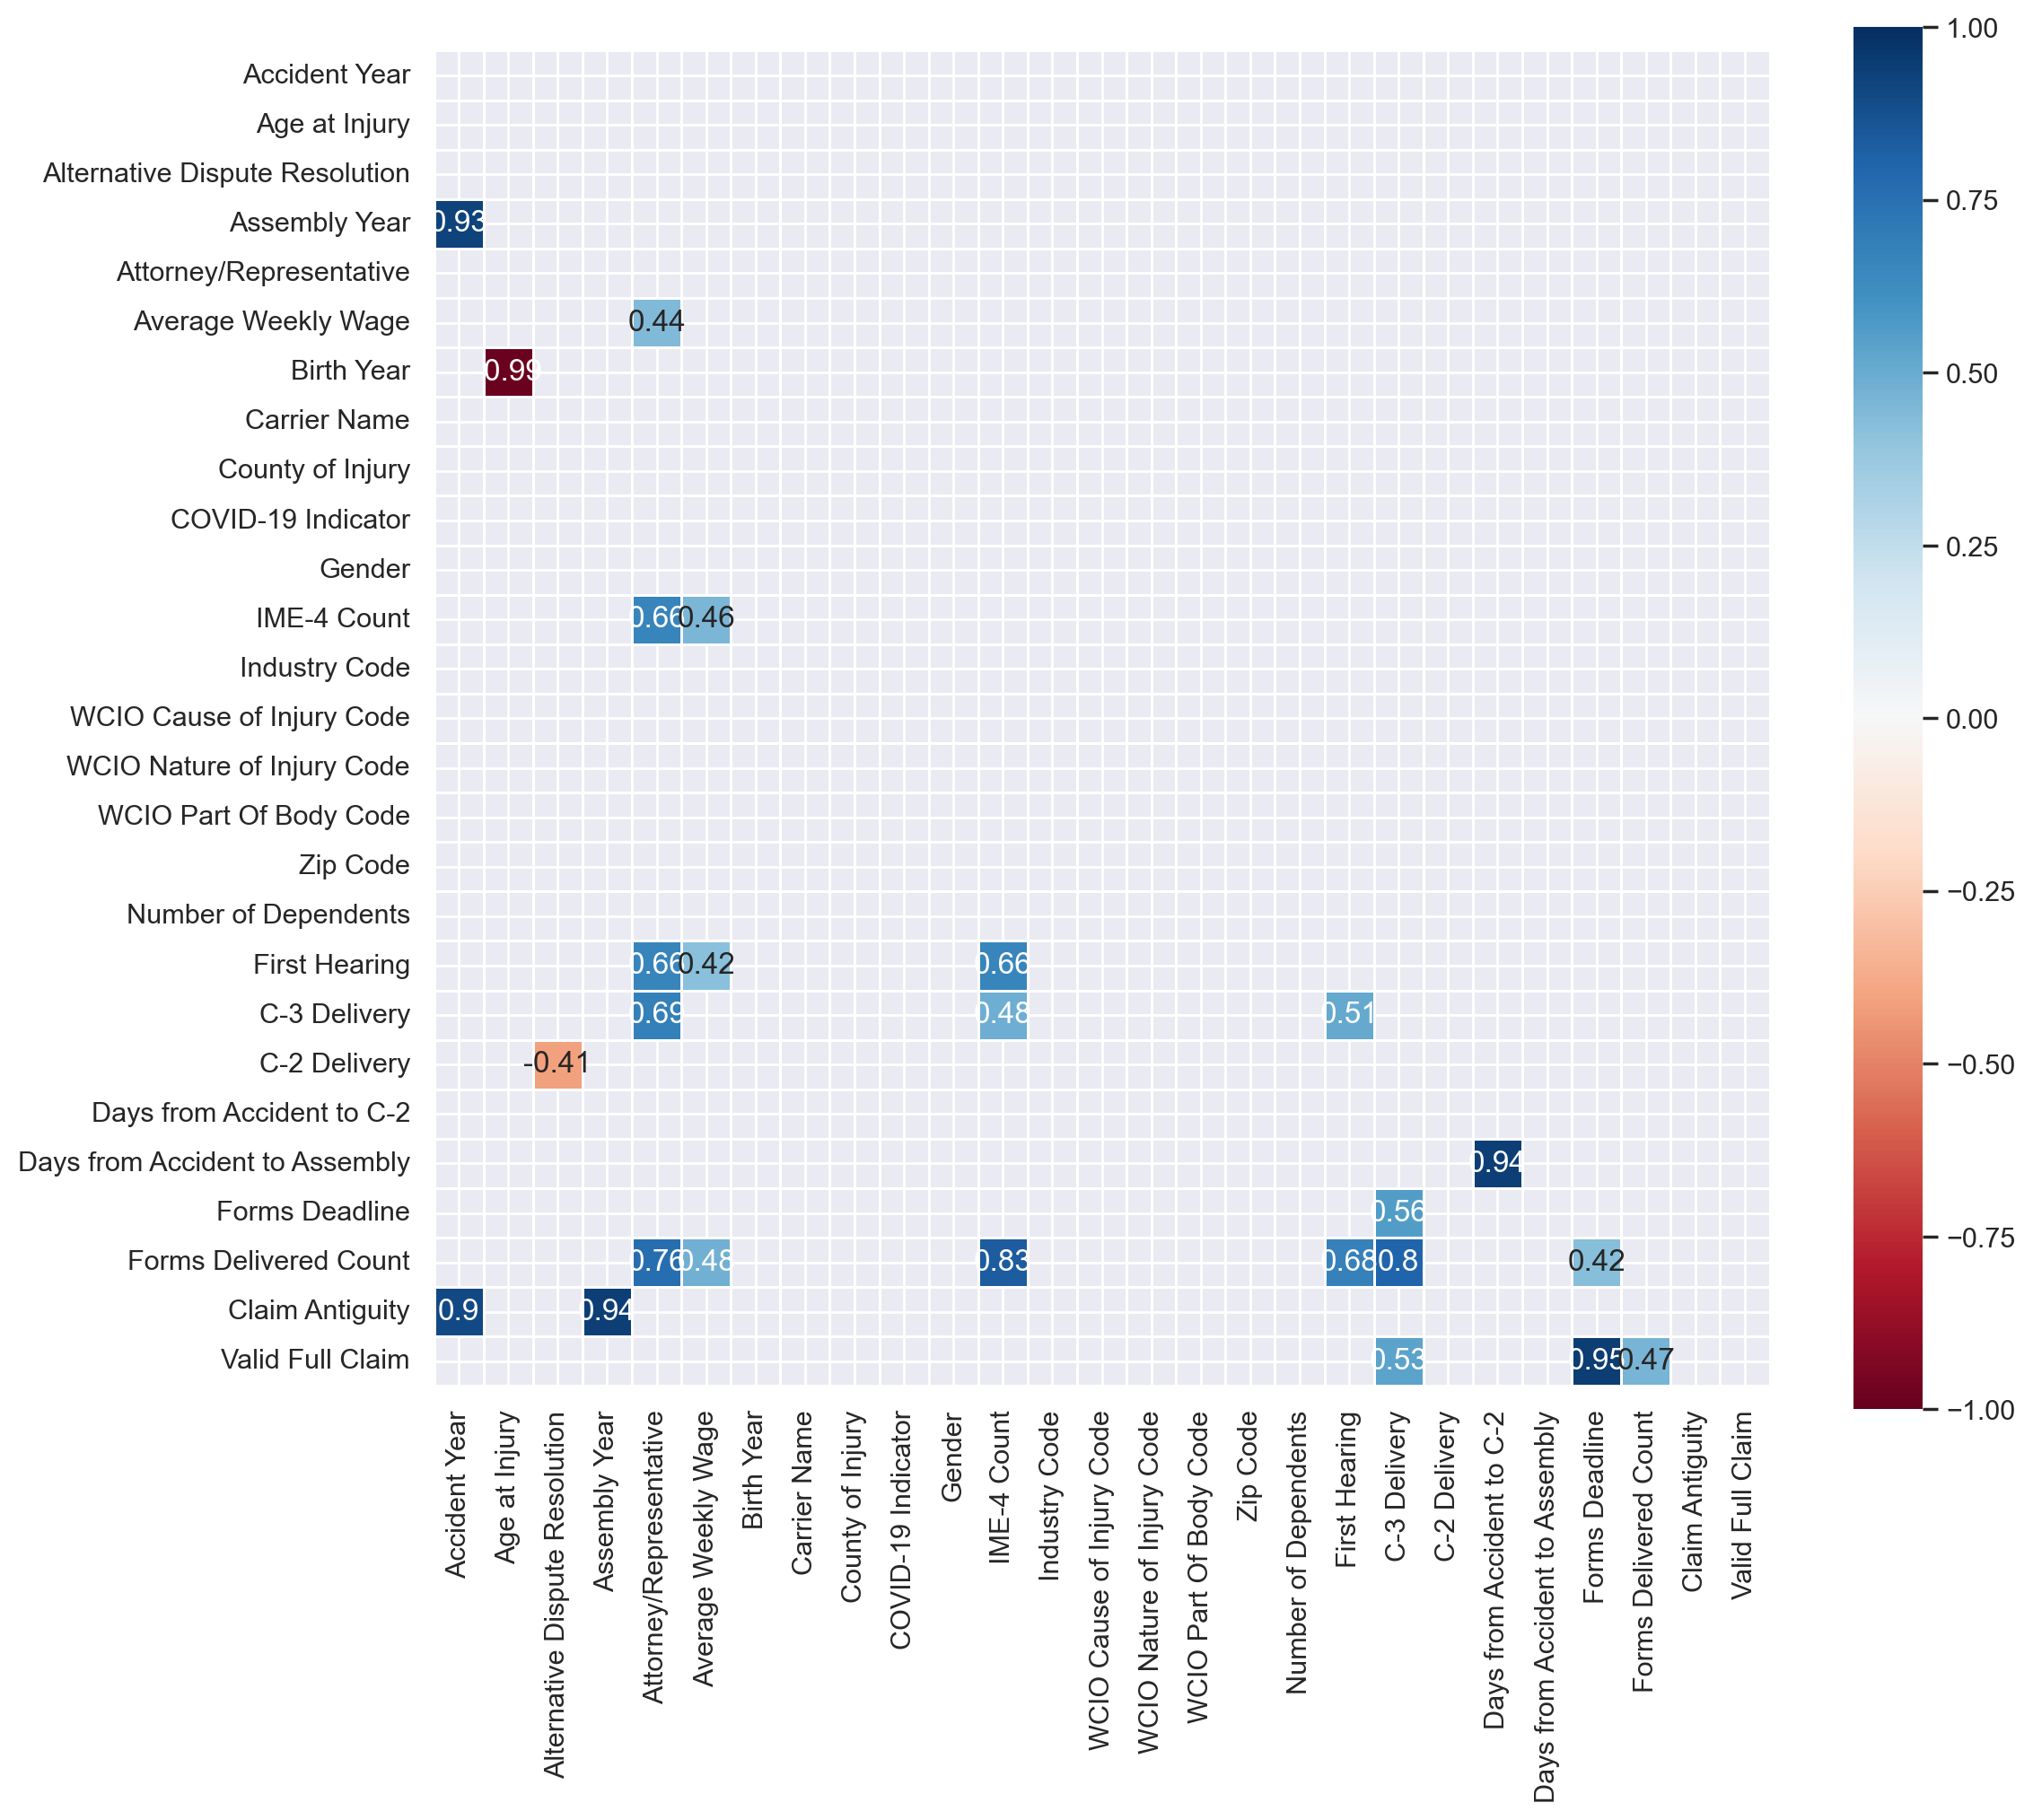

In [144]:
# CODE HERE
cor_spearman = X_train_num_scaled.corr(method ='spearman')
cor_heatmap(cor_spearman)

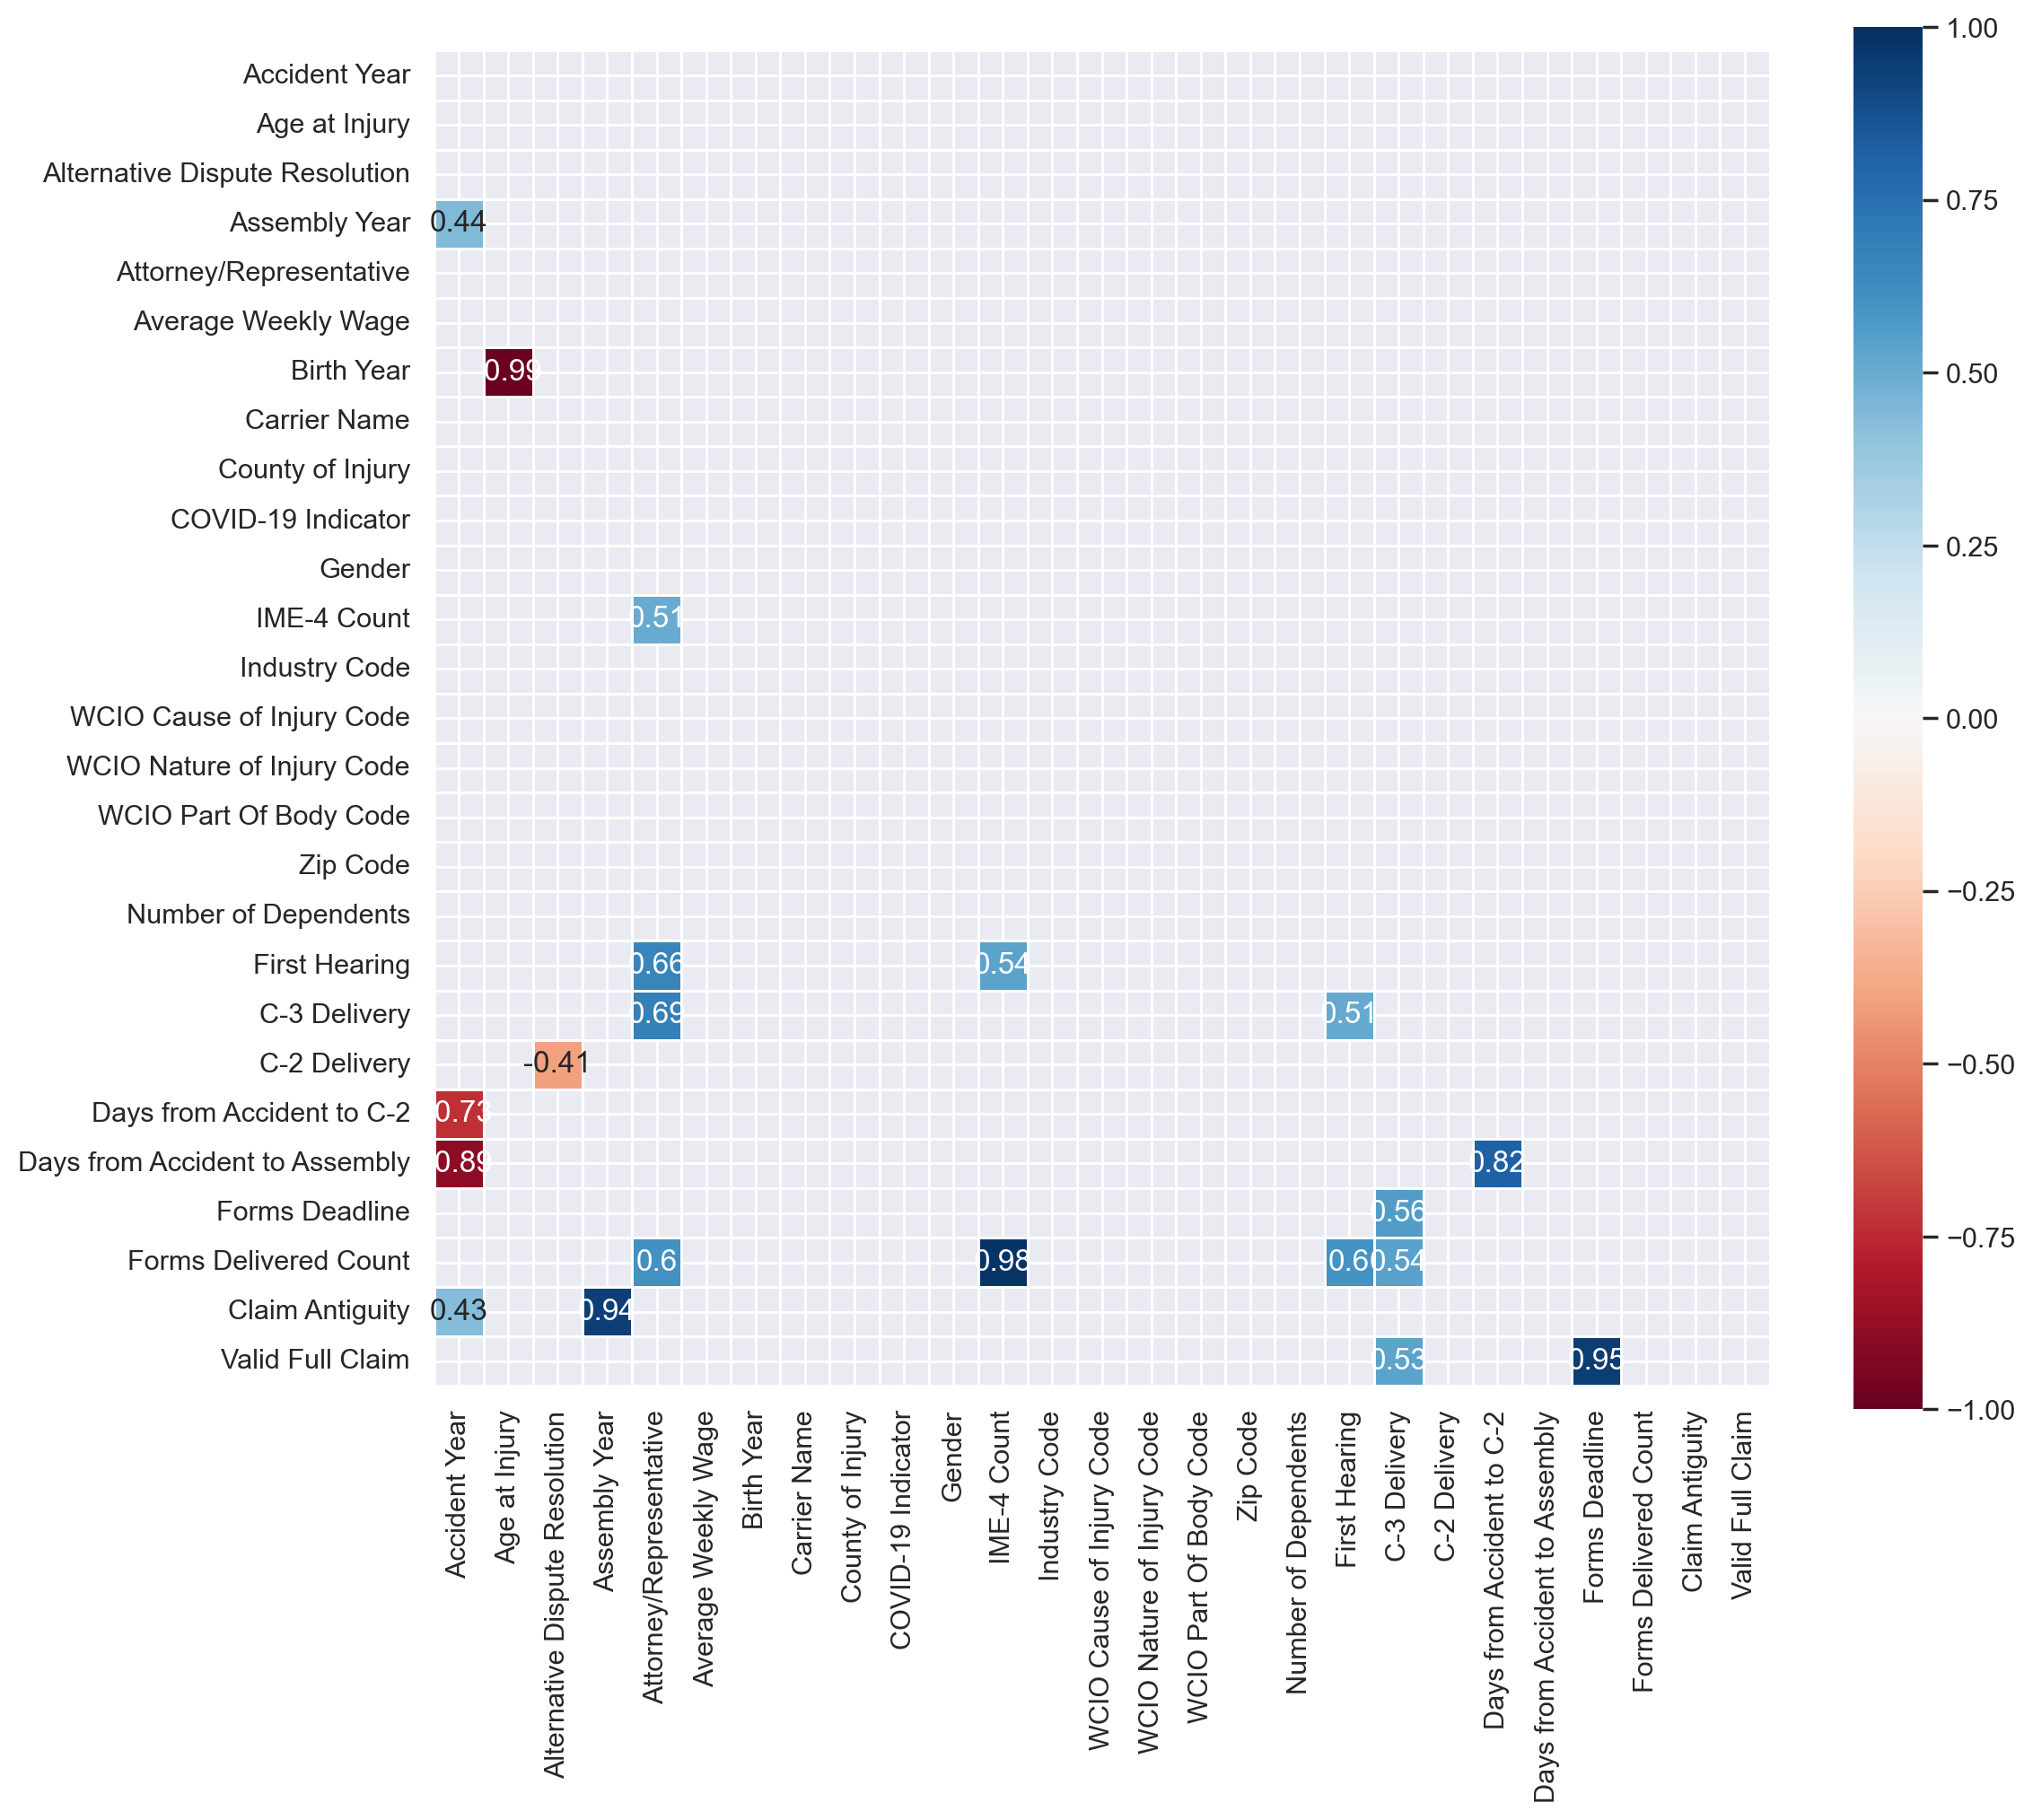

In [146]:
cor_pearson = X_train_num_scaled.corr(method='pearson')
cor_heatmap(cor_pearson)

In [149]:
def corr_pairs(corr, threshold):
    mask = np.tril(np.ones(corr.shape), k=-1).astype(bool)
    
    corr_lower = corr.where(mask)
    
    cor_pairs = corr_lower.unstack().dropna()
    cor_pairs = cor_pairs[(cor_pairs.abs() > threshold)]

    
    for pair, value in cor_pairs.items():
        feature_count_pair1 = len(corr[(corr[pair[0]].abs() > 0.2) & (corr[pair[0]].abs() < threshold)])
        feature_count_pair2 = len(corr[(corr[pair[1]].abs() > 0.2) & (corr[pair[1]].abs() < threshold)])
        
        print(f'{pair[0]} | significantly correlated with more {feature_count_pair1} features | or | {pair[1]} | significantly correlated with more {feature_count_pair2} features | {value:.2f}')

**If we consider a treshold of |0.70| for Pearson correlation, we have:**


In [152]:
corr_pairs(cor_pearson, threshold=0.7)

Accident Year | significantly correlated with more 2 features | or | Days from Accident to C-2 | significantly correlated with more 0 features | -0.73
Accident Year | significantly correlated with more 2 features | or | Days from Accident to Assembly | significantly correlated with more 0 features | -0.89
Age at Injury | significantly correlated with more 0 features | or | Birth Year | significantly correlated with more 0 features | -0.99
Assembly Year | significantly correlated with more 1 features | or | Claim Antiguity | significantly correlated with more 1 features | 0.94
IME-4 Count | significantly correlated with more 5 features | or | Forms Delivered Count | significantly correlated with more 5 features | 0.98
Days from Accident to C-2 | significantly correlated with more 0 features | or | Days from Accident to Assembly | significantly correlated with more 0 features | 0.82
Forms Deadline | significantly correlated with more 5 features | or | Valid Full Claim | significantly cor

**If we consider a treshold of |0.70| for Spearman correlation, we have:**


In [155]:
corr_pairs(cor_spearman, threshold=0.7)

Accident Year | significantly correlated with more 0 features | or | Assembly Year | significantly correlated with more 0 features | 0.93
Accident Year | significantly correlated with more 0 features | or | Claim Antiguity | significantly correlated with more 0 features | 0.90
Age at Injury | significantly correlated with more 0 features | or | Birth Year | significantly correlated with more 0 features | -0.99
Assembly Year | significantly correlated with more 0 features | or | Claim Antiguity | significantly correlated with more 0 features | 0.94
Attorney/Representative | significantly correlated with more 7 features | or | Forms Delivered Count | significantly correlated with more 4 features | 0.76
IME-4 Count | significantly correlated with more 6 features | or | Forms Delivered Count | significantly correlated with more 4 features | 0.83
C-3 Delivery | significantly correlated with more 6 features | or | Forms Delivered Count | significantly correlated with more 4 features | 0.80
D

In [157]:
drop_pearson = ['Days from Accident to C-2', 'Days from Accident to Assembly', 'Birth Year', 'Assembly Year', 'IME-4 Count', 'Forms Deadline']
                                                          

In [159]:
drop_spearman = ['Accident Year','Birth Year', 'Assembly Year', 'Forms Delivered Count', 'Days from Accident to Assembly', 'Forms Deadline']

## Option 1: Drop immediately these features, either based on intersection or union

In [161]:
drop_intersection = set(drop_pearson).intersection(drop_spearman)
drop_intersection

{'Assembly Year',
 'Birth Year',
 'Days from Accident to Assembly',
 'Forms Deadline'}

In [163]:
# Get the union of drop_pearson and drop_separman
drop_union = set(drop_pearson).union(drop_spearman)
drop_union

{'Accident Year',
 'Assembly Year',
 'Birth Year',
 'Days from Accident to Assembly',
 'Days from Accident to C-2',
 'Forms Deadline',
 'Forms Delivered Count',
 'IME-4 Count'}

In [165]:
'''# Drop those columns from the DataFrame
X_train_num_scaled = X_train_num_scaled.drop(columns=drop_intersection)

In [167]:
'''# Drop those columns from the DataFrame
X_val_num_scaled = X_val_num_scaled.drop(columns=drop_intersection)
X_test_num_scaled = X_test_num_scaled.drop(columns=drop_intersection)

## Option 2: Average it with other methods

In [243]:
selected_features_pearson = X_train_num.columns.difference(drop_pearson).tolist()
selected_features_pearson

['Accident Year',
 'Age at Injury',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Average Weekly Wage',
 'C-2 Delivery',
 'C-3 Delivery',
 'COVID-19 Indicator',
 'Carrier Name',
 'Claim Antiguity',
 'County of Injury',
 'First Hearing',
 'Forms Delivered Count',
 'Gender',
 'Industry Code',
 'Number of Dependents',
 'Valid Full Claim',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

In [245]:
selected_features_spearman = X_train_num.columns.difference(drop_spearman).tolist()
selected_features_spearman

['Age at Injury',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Average Weekly Wage',
 'C-2 Delivery',
 'C-3 Delivery',
 'COVID-19 Indicator',
 'Carrier Name',
 'Claim Antiguity',
 'County of Injury',
 'Days from Accident to C-2',
 'First Hearing',
 'Gender',
 'IME-4 Count',
 'Industry Code',
 'Number of Dependents',
 'Valid Full Claim',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

### 6.1.3. Chi-Square for categorical data

In [170]:
selected_features_chi = []

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
        selected_features_chi.append(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [172]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

District Name_BINGHAMTON is IMPORTANT for Prediction
District Name_BUFFALO is IMPORTANT for Prediction
District Name_HAUPPAUGE is IMPORTANT for Prediction
District Name_NYC is IMPORTANT for Prediction
District Name_ROCHESTER is IMPORTANT for Prediction
District Name_STATEWIDE is IMPORTANT for Prediction
District Name_SYRACUSE is IMPORTANT for Prediction
C-2 under Deadline_no is IMPORTANT for Prediction
C-2 under Deadline_yes is IMPORTANT for Prediction
C-3 under Deadline_no is IMPORTANT for Prediction
C-3 under Deadline_no info is IMPORTANT for Prediction
C-3 under Deadline_yes is IMPORTANT for Prediction
Carrier Type_2 is IMPORTANT for Prediction
Carrier Type_3 is IMPORTANT for Prediction
Carrier Type_4 is IMPORTANT for Prediction
Carrier Type_5 is IMPORTANT for Prediction
Medical Fee Region_2 is IMPORTANT for Prediction
Medical Fee Region_3 is IMPORTANT for Prediction
Medical Fee Region_4 is IMPORTANT for Prediction


In [174]:
selected_features_chi

['District Name_BINGHAMTON',
 'District Name_BUFFALO',
 'District Name_HAUPPAUGE',
 'District Name_NYC',
 'District Name_ROCHESTER',
 'District Name_STATEWIDE',
 'District Name_SYRACUSE',
 'C-2 under Deadline_no',
 'C-2 under Deadline_yes',
 'C-3 under Deadline_no',
 'C-3 under Deadline_no info',
 'C-3 under Deadline_yes',
 'Carrier Type_2',
 'Carrier Type_3',
 'Carrier Type_4',
 'Carrier Type_5',
 'Medical Fee Region_2',
 'Medical Fee Region_3',
 'Medical Fee Region_4']

In [ ]:
'''# first join all the training data
all_train = X_train.join(y_train)

def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins=True)
    categories = cont_tab.index[:-1]  # Exclude 'All' row
    category_indices = range(len(categories))  # Use integer positions

    target_classes = cont_tab.columns[:-1]  # Exclude 'All' column

    fig = plt.figure(figsize=(15, 5))

    # Frequency Bar Chart
    plt.subplot(121)
    bottom = np.zeros(len(categories))
    for cls in target_classes:
        plt.bar(category_indices, cont_tab[cls].iloc[:-1], 0.55, bottom=bottom, label=f'Class {cls}')
        bottom += cont_tab[cls].iloc[:-1].values
    plt.xticks(category_indices, categories, rotation=45)
    plt.title(f"Frequency Bar Chart: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend()

    # Proportion Bar Chart
    obs_pct = np.array([np.divide(cont_tab[cls].iloc[:-1].values, cont_tab.iloc[:-1, -1].values) for cls in target_classes])

    plt.subplot(122)
    bottom = np.zeros(len(categories))
    for i, cls in enumerate(target_classes):
        plt.bar(category_indices, obs_pct[i], 0.55, bottom=bottom, label=f'Class {cls}')
        bottom += obs_pct[i]
    plt.xticks(category_indices, categories, rotation=45)
    plt.title(f"Proportion Bar Chart: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Loop through all categorical
for feature in X_train_cat:
    print(f"Plotting for feature: {feature}")
    bar_charts_categorical(all_train, feature, "Claim Injury Type")

## 6.2 Wrapper Methods <a name="32-wrapper-methods"></a>

`Step 1` Join numerical and categorical data

In [176]:
print((X_train_num_scaled.index == X_train_cat.index).all())

True


In [178]:
# Join the numeric and categorical data for the training set
X_train_processed = X_train_num_scaled.join(X_train_cat, how='inner')

In [180]:
# Join the numeric and categorical data for the validation set
X_val_processed = X_val_num_scaled.join(X_val_cat, how='inner')
# Join the numeric and categorical data for the test set
X_test_processed = X_test_num_scaled.join(X_test_cat, how='inner')

In [182]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 65312 to 133536
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Year                   401818 non-null  float64
 1   Age at Injury                   401818 non-null  float64
 2   Alternative Dispute Resolution  401818 non-null  float64
 3   Attorney/Representative         401818 non-null  float64
 4   Average Weekly Wage             401818 non-null  float64
 5   Carrier Name                    401818 non-null  float64
 6   County of Injury                401818 non-null  float64
 7   COVID-19 Indicator              401818 non-null  float64
 8   Gender                          401818 non-null  float64
 9   IME-4 Count                     401818 non-null  float64
 10  Industry Code                   401818 non-null  float64
 11  WCIO Cause of Injury Code       401818 non-null  float64
 12  WCIO Nature of In

### 6.2.1 RFE <a name="321-rfe"></a>

### Logistic Regression Classifier

In [184]:
model = LogisticRegression()

In [186]:
# CODE HERE
rfe = RFE(estimator = model, n_features_to_select = 16)
#optimal number

In [188]:
# CODE HERE
X_rfe = rfe.fit_transform(X = X_train_processed, y = y_train)

In [189]:
# CODE HERE
X_train_processed.columns

Index(['Accident Year', 'Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'County of Injury', 'COVID-19 Indicator', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents', 'First Hearing', 'C-3 Delivery', 'C-2 Delivery',
       'Days from Accident to C-2', 'Forms Delivered Count', 'Claim Antiguity',
       'Valid Full Claim', 'District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE', 'C-2 under Deadline_no',
       'C-2 under Deadline_yes', 'C-3 under Deadline_no',
       'C-3 under Deadline_no info', 'C-3 under Deadline_yes',
       'Carrier Type_2', 'Carrier Type_3', 'Carrier Type_4', 'Carrier Type_5',
       'Medical Fee Region_2', 'Medi

In [190]:
rfe.support_

array([ True, False,  True,  True, False,  True, False,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False])

In [191]:
rfe.ranking_

array([ 1,  5,  1,  1, 26,  1, 17,  1, 13,  1,  9, 10,  1,  1, 27, 20,  1,
        1,  1,  1,  1,  3,  4, 24, 14, 18, 11, 15,  7, 23,  6,  8, 12,  1,
        1,  1, 16, 25,  2, 19, 22, 21])

In [192]:
selected_features_rfe = pd.Series(rfe.support_, index=X_train_processed.columns)

selected_features_rfe = selected_features_rfe[selected_features_rfe == True].index.to_list()

selected_features_rfe

['Accident Year',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'COVID-19 Indicator',
 'IME-4 Count',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'First Hearing',
 'C-3 Delivery',
 'C-2 Delivery',
 'Days from Accident to C-2',
 'Forms Delivered Count',
 'C-3 under Deadline_no info',
 'C-3 under Deadline_yes',
 'Carrier Type_2']

**Optimal number of features for RFE LR:**

In [ ]:
#no of features
nof_list=np.arange(1,18)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        # Record the selected features
        features_to_select_rfe = pd.Series(rfe.support_, index=X_train_num.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
train_score_list

In [ ]:
plt.plot(list(range(1,18)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,18)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

### Support Vector Machine Classifier

In [ ]:
model = SVC(kernel='linear')
rfe = RFE(estimator = model, n_features_to_select = 16)

In [ ]:
rfe = RFE(estimator = model, n_features_to_select = 16)

In [ ]:
X_rfe = rfe.fit_transform(X = X_train_processed, y = y_train)

In [ ]:
rfe.support_

In [ ]:
rfe.ranking_

In [ ]:
selected_features_svm = pd.Series(rfe.support_, index=X_train_processed.columns)

selected_features_svm = selected_features_svm[selected_features_svm == True].index.to_list()

selected_features_svm

**Optimal number of features for RFE SVM, using Grid Search for cross validation:**

In [ ]:
#Define pipeline with RFE and SVC
pipeline = Pipeline([
    ('rfe', RFE(estimator=SVC(kernel='linear'))),
    ('svc', SVC(kernel='linear'))])

# Define parameter grid
param_grid = {
    'rfe__n_features_to_select': range(5, X_train_processed.shape[1] + 1, 5)}  # Test different numbers of features}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

print("Best number of features:", grid_search.best_params_['rfe__n_features_to_select'])
print("Best cross-validated score:", grid_search.best_score_)

In [ ]:
#FROM LAB - DOESN'T RUN UNTIL END

'''nof_list = np.arange(1, 18)
high_score = 0
nof = 0  # Variable to store the optimum number of features
train_score_svm_list = []
val_score_svm_list = []

for n in range(len(nof_list)):
    # Instantiate SVM model
    model = SVC(kernel='linear')
    
    # Create RFE instance with a specified number of features
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    
    # Fit RFE and transform training data, transform validation data
    X_train_rfe = rfe.fit_transform(X_train_num, y_train)
    X_val_rfe = rfe.transform(X_val_num)
    
    # Fit model on transformed training data
    model.fit(X_train_rfe, y_train)
    
    # Record training score
    train_score_svm = model.score(X_train_rfe, y_train)
    train_score_svm_list.append(train_score_svm)
    
    # Record validation score
    val_score_svm = model.score(X_val_rfe, y_val)
    val_score_svm_list.append(val_score_svm)
    
    # Update best score if current validation score is higher
    if val_score_svm > high_score:
        high_score = val_score_svm
        nof = nof_list[n]
        
        # Record the selected features
        features_to_select_svm = pd.Series(rfe.support_, index=X_train_num.columns)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select_svm}")

In [ ]:
'''plt.plot(list(range(1,18)), train_score_svm_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,18)), val_score_svm_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

## 6.3 Embedded Methods <a name="33-embedded-methods"></a>

### 6.3.1 Lasso <a name="331-lasso"></a>

In [198]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [200]:
reg = LassoCV()

In [202]:
reg.fit(X_train_processed, y_train)

LassoCV()

In [203]:
coef = pd.Series(reg.coef_, index = X_train_processed.columns)
coef.sort_values()

Carrier Type_2                   -0.429021
District Name_STATEWIDE          -0.304345
COVID-19 Indicator               -0.169202
Claim Antiguity                  -0.162430
C-3 Delivery                     -0.157757
District Name_NYC                -0.085539
Medical Fee Region_4             -0.024531
County of Injury                 -0.006795
Medical Fee Region_2             -0.005430
Medical Fee Region_3             -0.003990
Carrier Type_4                   -0.002808
C-3 under Deadline_no             0.000000
Days from Accident to C-2        -0.000000
Number of Dependents             -0.000000
Accident Year                    -0.000000
Forms Delivered Count             0.000000
Average Weekly Wage               0.000000
Zip Code                          0.000000
C-3 under Deadline_no info        0.000147
WCIO Nature of Injury Code        0.053185
District Name_HAUPPAUGE           0.054301
District Name_ROCHESTER           0.056475
District Name_BINGHAMTON          0.059946
Industry Co

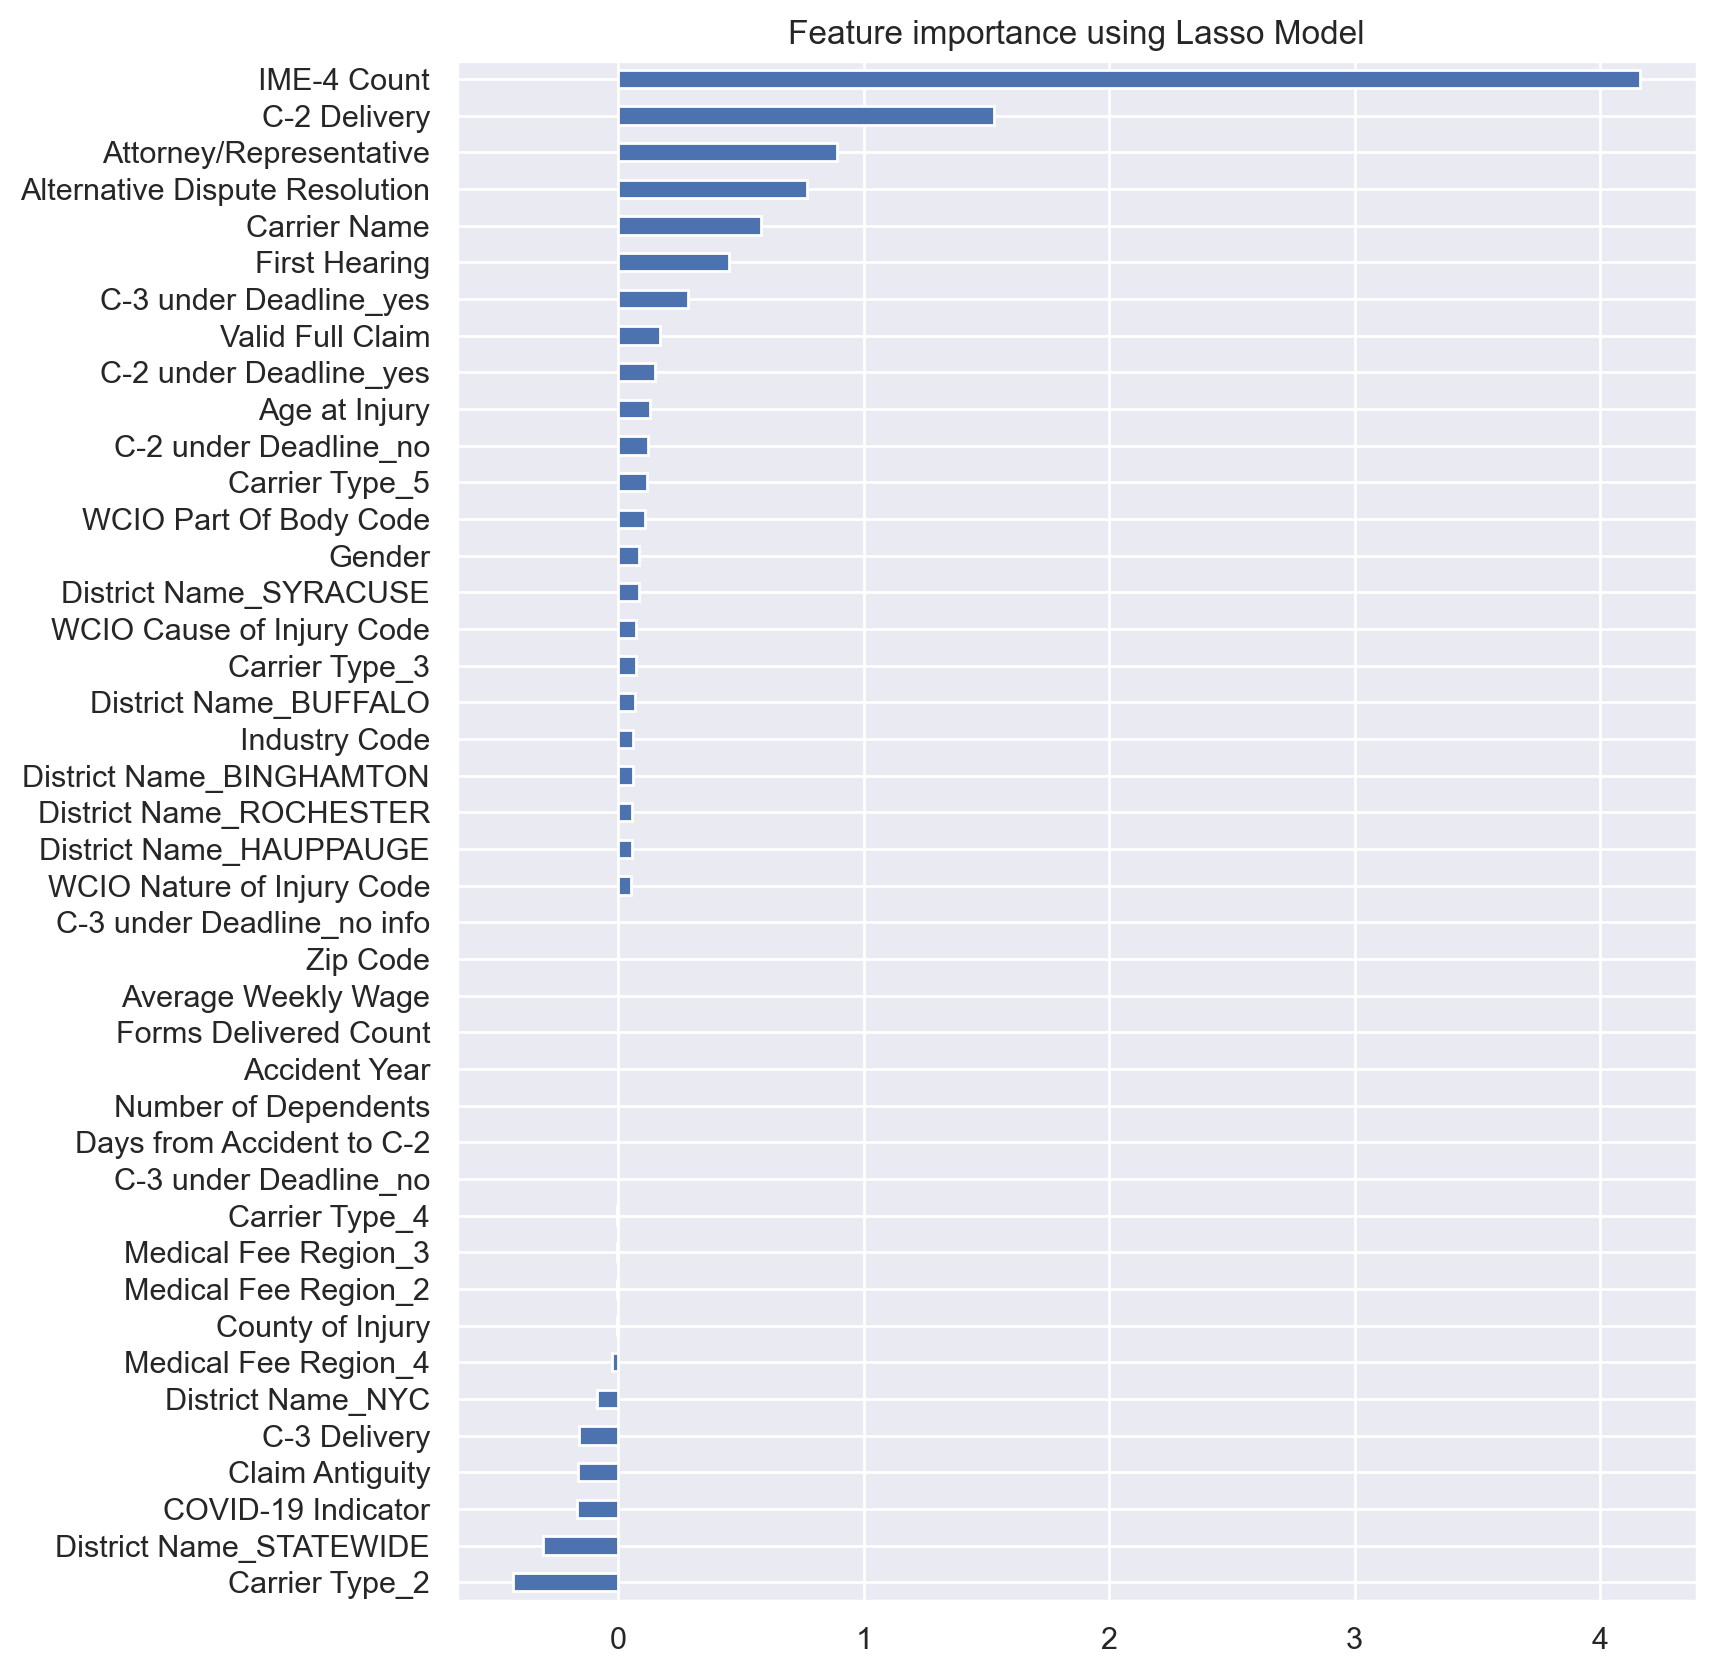

In [204]:
# CODE HERE
plot_importance(coef,'Lasso')

In [205]:
# CODE HERE
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

selected_features_lasso = coef[coef.abs() != 0.00].index.to_list()

selected_features_lasso

Lasso picked 35 variables and eliminated the other 7 variables


['Age at Injury',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'County of Injury',
 'COVID-19 Indicator',
 'Gender',
 'IME-4 Count',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'First Hearing',
 'C-3 Delivery',
 'C-2 Delivery',
 'Claim Antiguity',
 'Valid Full Claim',
 'District Name_BINGHAMTON',
 'District Name_BUFFALO',
 'District Name_HAUPPAUGE',
 'District Name_NYC',
 'District Name_ROCHESTER',
 'District Name_STATEWIDE',
 'District Name_SYRACUSE',
 'C-2 under Deadline_no',
 'C-2 under Deadline_yes',
 'C-3 under Deadline_no info',
 'C-3 under Deadline_yes',
 'Carrier Type_2',
 'Carrier Type_3',
 'Carrier Type_4',
 'Carrier Type_5',
 'Medical Fee Region_2',
 'Medical Fee Region_3',
 'Medical Fee Region_4']

## Decision Trees

In [207]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_processed, y_train)

feature_importances = pd.Series(model.feature_importances_, index=X_train_processed.columns)

mean_importance = feature_importances.mean()
selected_features_dt = feature_importances[feature_importances > mean_importance].index.to_list()

selected_features_dt

['Age at Injury',
 'Attorney/Representative',
 'Average Weekly Wage',
 'Carrier Name',
 'County of Injury',
 'IME-4 Count',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code',
 'Number of Dependents',
 'Days from Accident to C-2',
 'Claim Antiguity']

## Random Forest Classifier

In [209]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_processed, y_train)

mean_importance = model.feature_importances_.mean()
threshold_value = mean_importance

selector = SelectFromModel(model, threshold=threshold_value, prefit=True)
selected_features = X_train_processed.columns[(selector.get_support())]

selected_features_rf = selected_features.to_list()

print("Selected Features:", selected_features_rf)

Selected Features: ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name', 'County of Injury', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents', 'First Hearing', 'Days from Accident to C-2', 'Forms Delivered Count', 'Claim Antiguity']


## 6.4 Final Insights <a name="34-final-insights"></a>

### For numerical Data:

In [247]:
data = {'Feature': X_train_processed.columns}

data['Pearson'] = ['Keep' if feature in selected_features_pearson else 'Not Tested' if feature not in X_train_num_scaled.columns else 'Discard' for feature in X_train_processed.columns]
data['Spearman'] = ['Keep' if feature in selected_features_spearman else 'Not Tested' if feature not in X_train_num_scaled.columns else 'Discard' for feature in X_train_processed.columns]
data['LASSO'] = ['Keep' if feature in selected_features_lasso else 'Discard' for feature in X_train_processed.columns]
data['RFE LR'] = ['Keep' if feature in selected_features_rfe else 'Discard' for feature in X_train_processed.columns]
data['DT'] = ['Keep' if feature in selected_features_dt else 'Discard' for feature in X_train_processed.columns]
data['RandomForest'] = ['Keep' if feature in selected_features_rf else 'Discard' for feature in X_train_processed.columns]
#data['RFE SVM'] = ['Keep' if feature in selected_features_svm else 'Discard' for feature in X_train_num_scaled.columns]
data['Chi Square'] = ['Keep' if feature in selected_features_chi else 'Not Tested' if feature not in X_train_cat.columns else 'Discard' for feature in X_train_processed.columns]


df = pd.DataFrame(data)
df['Result'] = df.iloc[:, 1:].apply(
    lambda x: 'Keep' if list(x[x != 'Not Tested']).count('Keep') >= list(x[x != 'Not Tested']).count('Discard') 
    else 'Discard', 
    axis=1)


feature_selection = df[df['Result'] == 'Keep']['Feature'].tolist()

def color_cells(val):
    if val == 'Keep':
        return 'background-color: lightgreen'
    elif val == 'Discard':
        return 'background-color: lightcoral'
    else:  # For "Not Tested" or other cases, no color
        return ''

styled_df = df.style.applymap(color_cells, subset=df.columns[1:])

styled_df

,Feature,Pearson,Spearman,LASSO,RFE LR,DT,RandomForest,Chi Square,Result
0,Accident Year,Keep,Discard,Discard,Keep,Discard,Discard,Not Tested,Discard
1,Age at Injury,Keep,Keep,Keep,Discard,Keep,Keep,Not Tested,Keep
2,Alternative Dispute Resolution,Keep,Keep,Keep,Keep,Discard,Discard,Not Tested,Keep
3,Attorney/Representative,Keep,Keep,Keep,Keep,Keep,Keep,Not Tested,Keep
4,Average Weekly Wage,Keep,Keep,Discard,Discard,Keep,Keep,Not Tested,Keep
5,Carrier Name,Keep,Keep,Keep,Keep,Keep,Keep,Not Tested,Keep
6,County of Injury,Keep,Keep,Keep,Discard,Keep,Keep,Not Tested,Keep
7,COVID-19 Indicator,Keep,Keep,Keep,Keep,Discard,Discard,Not Tested,Keep
8,Gender,Keep,Keep,Keep,Discard,Discard,Discard,Not Tested,Keep
9,IME-4 Count,Discard,Keep,Keep,Keep,Keep,Keep,Not Tested,Keep


In [249]:
feature_selection

['Age at Injury',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Average Weekly Wage',
 'Carrier Name',
 'County of Injury',
 'COVID-19 Indicator',
 'Gender',
 'IME-4 Count',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code',
 'Number of Dependents',
 'First Hearing',
 'C-3 Delivery',
 'C-2 Delivery',
 'Days from Accident to C-2',
 'Forms Delivered Count',
 'Claim Antiguity',
 'Valid Full Claim',
 'C-3 under Deadline_no info',
 'C-3 under Deadline_yes',
 'Carrier Type_2']

In [251]:
len(feature_selection)

25

In [254]:
X_train_processed_copy = X_train_processed.copy()
X_val_processed_copy= X_val_processed.copy()
X_test_processed_copy = X_test_processed.copy()

## Export Datasets and variables for following notebook

In [261]:
variables = {
    "feature_selection": feature_selection,
    "selected_features_rf": selected_features_rf,
    "selected_features_dt": selected_features_dt,
   #"selected_features_svm": selected_features_svm,
    "selected_features_rfe": selected_features_rfe}

with open('variables.py', 'w') as f:
    for var_name, value in variables.items():
        f.write(f"{var_name} = {repr(value)}\n")

In [263]:
X_train_processed.to_csv('X_train_processed.csv', index=True)
X_val_processed.to_csv('X_val_processed.csv', index=True)
X_test_processed.to_csv('X_test_processed.csv', index=True)

In [273]:
X_train_processed_copy.to_csv('X_train_processed_copy.csv', index=True)
X_val_processed_copy.to_csv('X_val_processed_copy.csv', index=True)
X_test_processed_copy.to_csv('X_test_processed_copy.csv', index=True)